In [69]:
import random
import numpy as np
from tqdm import tqdm

# Rover
**Monte Carlo Control**

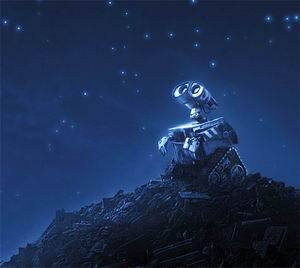

Consider a rover that is trying to move up the hill. The robot has solar powered motors. Once the robot **reaches the top** of the hill, the **episode ends**. The Robot can either be at **low, medium, high or top** of the hill at any given point of time.

The robot can either decide to spin it's wheels **slowly or rapidly** in order to move up on the gradient.

- If the **motor spins the wheel slowly**, with probability `0.6` it moves to the next higher state in one time step, and with probability `0.4`, it slides all the way down the slope to the low state.
- On the other hand, if the **motor spins the wheel rapidly**, with probability `0.9` it moves to the next higher state in one time step, and with probability `0.1`, it slides all the way down the slope to the low state.

The robot initially starts from low state with 10 units of energy (battery charge). The **episode ends** if the batteries get completely discharged or if rover reaches the top position.

The rover has a motor that can spin its wheel
- slowly at the expense of 2 unit of energy per time step;
- or rapidly at the expense of 4 units of energy per time step.

**rover gains 4 units of energy** per time step from its solar panels any time it transitions **upward from the medium position** as it gets exposed to sunlight.

### Goal:
The Robot has to reach the top with maximum amount of energy left in the battery (Energy spent while moving to the top must be minimum)

### Tasks

##### PART 1
- Create an "Environment" class that has the step() method which takes in an action and returns the next state and one step reward.

- Try taking random actions until the eposode terminates. Print the one-step reward, action and next state for all transitions in the episode. What is the average total reward if you run the experiment over many episodes?  

- What is the average total reward over 10,000 episodes if:
    - Actions are chosen "randmoly" from the action space?
    - Action is always "spin_slowly"?  
    - Acion is always "spin_rapidly"?

##### PART 2
- Create an "Agent" class with train() and policy() methoods which learns to take actions in this environment. Agent should be trainable using Monte-Carlo Control.

- Train the agent. What is the average total return after training the Agent?

    *(optional)*
- Perform monte-carlo prediction of state-values to evaluate the learned policy. How valuable is it to start from each state?

-------------

In [128]:
import random
INITIAL_STATE = "low"
INITIAL_CHARGE = 10

class RoverEnv:
    
    def __init__(self):
        """
        Initializes the environment with the specified state and action spaces,
        as well as initial charge and terminated flag.
        """
        self.action_space = ["spin_slowly", "spin_rapidly"]
        self.observation_space = ["low", "medium", "high", "top"]
        self.reset()

    def reset(self):
        """
        Resets the environment to its initial state.
        """
        self.state = INITIAL_STATE  # "low"
        self.charge = INITIAL_CHARGE  # 10
        self.terminated = False
        self.total_reward = 0  # Track total reward for one episode

    def get_transition_probability(self, start_state, end_state, action):
        """
        Calculates the transition probability from one state to another
        given an action. Uses a dictionary for efficient lookup.

        Args:
            start_state: The starting state ("low", "medium", "high", or "top").
            end_state: The ending state ("low", "medium", "high", or "top").
            action: The action taken ("spin_slowly" or "spin_rapidly").

        Returns:
            The probability of transitioning to the end_state from the
            start_state given the action, or 0 if the transition is invalid.
        """
        transition_probs = {
            "low": {
                "spin_slowly": {"medium": 0.6, "low": 0.4},
                "spin_rapidly": {"medium": 0.9, "low": 0.1},
            },
            "medium": {
                "spin_slowly": {"high": 0.6, "low": 0.4},
                "spin_rapidly": {"high": 0.9, "low": 0.1},
            },
            "high": {
                "spin_slowly": {"top": 0.8, "medium": 0.2},
                "spin_rapidly": {"top": 0.95, "medium": 0.05},
            },
        }
        if start_state not in transition_probs or action not in transition_probs[start_state]:
            return 0
        return transition_probs[start_state][action].get(end_state, 0)

    def get_charge_difference(self, start_state, end_state, action):
        """
        Calculates the change in charge due to the action taken and solar panel charge gain.

        Args:
            start_state: The starting state ("low", "medium", or "high").
            end_state: The ending state ("medium", "high", or "top").
            action: The action taken ("spin_slowly" or "spin_rapidly").

        Returns:
            The difference in charge due to the action and solar panel gain.
        """
        charge_diff = 0
        charge_cost = {"spin_slowly": 2, "spin_rapidly": 4}
        charge_diff -= charge_cost[action]  # Subtract action cost

        # if start_state == "medium" and end_state == "high" :
        if start_state == "medium" and end_state == "high":

            charge_diff += 4  # Gain charge from solar panels
        
        elif start_state == "high" and end_state == "top":
            charge_diff += 4

        return charge_diff

    def get_reward(self, end_state):
        """
        Calculates the episode reward based on the final state.

        Args:
            end_state: The final state of the episode ("low", "medium", "high", or "top").

        Returns:
            The episode reward, which is the remaining charge if the robot reaches
            the top, or 0 otherwise.
        """
        if end_state == "top":
            return self.charge
        return 0

    def step(self, action):
        """
        Takes a step in the environment, updates the state, charge, and termination flag.

        Args:
            action: The action taken by the agent ("spin_slowly" or "spin_rapidly").

        Returns:
            A tuple containing the next state, one-step reward, and termination flag.
        """

        if self.state == "top":
            self.terminated = True
            return self.state, self.charge, self.terminated

        # Sample the next state based on the transition probability for the chosen action
        possible_next_states = list(self.get_transition_probability(self.state, next_state, action) for next_state in self.observation_space)
        next_state = random.choices(self.observation_space, weights=possible_next_states)[0]

        # Calculate the change in charge due to the action and solar panel gain
        charge_diff = self.get_charge_difference(self.state, next_state, action)

        # Update the charge
        self.charge += charge_diff
        if self.charge < 0:
            self.charge = 0  # Clip charge to 0 (no negative charge)

        # Update the state
        self.state = next_state

        # Calculate the one-step reward based on the final state
        one_step_reward = self.get_reward(self.state)

        # Update termination flag
        if self.state == "top" or self.charge <= 0:
            self.terminated = True

        # Track total reward for the episode
        self.total_reward += one_step_reward

        return self.state, one_step_reward, self.terminated

In [149]:
class MonteCarloAgent:
  """
  Monte Carlo agent class that learns an action-value function (Q-value) 
  for an environment using Monte Carlo Control with First-visit Monte Carlo update.
  """

  def __init__(self, env):
    """
    Initializes the agent with the environment and data structures.

    Args:
        env: The environment to interact with.
    """
    self.env = env
    self.Q = {}  # Dictionary to store action-value estimates (Q-values)
    self.N = {}  # Dictionary to track visit counts for each (state, action) pair
    self.reset()  # Initialize episode data

  def reset(self):
    """
    Resets the agent's episode data for a new learning episode.
    """
    self.episode = []  # List to store state, action, reward tuples for the current episode

  def train(self, num_episodes=10000, epsilon=0.1,gamma=0.9):
    """
    Trains the agent using Monte Carlo Control for a specified number of episodes.

    Args:
        num_episodes: The number of episodes to train for (default: 10000).
        epsilon: The exploration rate for epsilon-greedy policy (default: 0.1).
    """
    for _ in range(num_episodes):
      self.reset()
      self.generate_episode(epsilon)  # Generate an episode using the current policy
      # self.update_Q()  # Update Q-values based on the episode experience
      self.update_Q(gamma)  # Update Q-values based on the episode experience


  def generate_episode(self, epsilon):
    """
    Generates an episode by interacting with the environment and collecting experience.

    Args:
        epsilon: The exploration rate for epsilon-greedy policy (default: 0.1).
    """
    state = self.env.reset()  # Get initial state
    done = False
    while not done:
      action = self.policy(state, epsilon)  # Choose an action based on the policy
      next_state, reward, done = self.env.step(action)  # Step in the environment
      self.episode.append((state, action, reward))  # Record the experience
      state = next_state  # Update current state

  def update_Q(self, gamma):
    """
    Updates the Q-values for each state-action pair visited in the episode using First-visit Monte Carlo update.
    """
    G = 0  # Initialize return (discounted reward sum)
    for state, action, reward in reversed(self.episode):
        G = reward + gamma * G  # Update return
        self.N[(state, action)] = self.N.get((state, action), 0) + 1  # Increment visit count
        self.Q[(state, action)] = self.Q.get((state, action), 0) + (G - self.Q.get((state, action), 0)) / self.N[(state, action)]
  def policy(self, state, epsilon):
    """
    Chooses an action based on an epsilon-greedy policy.

    Args:
        state: The current state of the environment.
        epsilon: The exploration rate (default: 0.1).

    Returns:
        The action chosen by the agent.
    """
    if random.uniform(0, 1) < epsilon:  # Exploration: choose a random action
      return random.choice(self.env.action_space)
    else:  # Exploitation: choose the action with the highest Q-value for the state
      Q_values = [self.Q.get((state, action), 0) for action in self.env.action_space]  # Get Q-values for all actions
      return self.env.action_space[np.argmax(Q_values)]  # Return the action with the highest Q-value
    
  def print_Q_values(self):
    """
    Prints the Q-values learned by the agent.
    """
    for (state, action), value in self.Q.items():
        print(f"Q({state}, {action}) = {round(value, 3)}")

----

Part 1 

Try taking random actions until the eposode terminates. Print the one-step reward, action and next state for all transitions in the episode. What is the average total reward if you run the experiment over many episodes?

In [129]:
def random_experiment(agent, num_episodes=1000):
    total_reward = 0
    for _ in range(num_episodes):
        state = agent.env.reset()
        episode_reward = 0
        while not agent.env.terminated:
            action = random.choice(agent.env.action_space)  # Take a random action
            next_state, reward, done = agent.env.step(action)
            episode_reward += reward
            print(f"Action: {action}, Reward: {reward}, Next State: {next_state}")
            state = next_state
        total_reward += episode_reward
    average_reward = total_reward / num_episodes
    return average_reward

# Run the experiment and print the average reward
average_reward = random_experiment(agent, num_episodes=1000)
print(f"\nAverage Total Reward over {num_episodes} episodes: {average_reward}")

Action: spin_rapidly, Reward: 0, Next State: medium
Action: spin_rapidly, Reward: 0, Next State: high
Action: spin_slowly, Reward: 0, Next State: medium
Action: spin_rapidly, Reward: 0, Next State: high
Action: spin_slowly, Reward: 2, Next State: top
Action: spin_slowly, Reward: 0, Next State: low
Action: spin_slowly, Reward: 0, Next State: low
Action: spin_rapidly, Reward: 0, Next State: medium
Action: spin_slowly, Reward: 0, Next State: low
Action: spin_slowly, Reward: 0, Next State: medium
Action: spin_slowly, Reward: 0, Next State: high
Action: spin_rapidly, Reward: 6, Next State: top
Action: spin_slowly, Reward: 0, Next State: low
Action: spin_slowly, Reward: 0, Next State: medium
Action: spin_slowly, Reward: 0, Next State: low
Action: spin_slowly, Reward: 0, Next State: medium
Action: spin_slowly, Reward: 0, Next State: low
Action: spin_rapidly, Reward: 0, Next State: low
Action: spin_rapidly, Reward: 0, Next State: medium
Action: spin_slowly, Reward: 0, Next State: high
Action: 

---

What is the average total reward over 10,000 episodes if:

Actions are chosen "randmoly" from the action space?
Action is always "spin_slowly"?
Acion is always "spin_rapidly"?

In [130]:
def run_episode(env, action_policy):
    state = env.reset()
    total_reward = 0
    while True:
        action = action_policy(state)
        next_state, reward, done = env.step(action)
        total_reward += reward
        state = next_state
        if done:
            break
    return total_reward

In [131]:
def random_policy(state):
    return random.choice(env.action_space)

def slow_spin_policy(state):
    return "spin_slowly"

def rapid_spin_policy(state):
    return "spin_rapidly"

In [150]:
env = RoverEnv()
num_episodes = 10000

# Experiment 1: Random policy
total_reward = sum(run_episode(env, random_policy) for _ in range(num_episodes))
print(f"Average total reward with random policy: {total_reward / num_episodes}")

# Experiment 2: Slow spin policy
total_reward = sum(run_episode(env, slow_spin_policy) for _ in range(num_episodes))
print(f"Average total reward with slow spin policy: {total_reward / num_episodes}")

# Experiment 3: Rapid spin policy
total_reward = sum(run_episode(env, rapid_spin_policy) for _ in range(num_episodes))
print(f"Average total reward with rapid spin policy: {total_reward / num_episodes}")

Average total reward with random policy: 5.652
Average total reward with slow spin policy: 6.88
Average total reward with rapid spin policy: 4.8296


------------------

part 2

In [151]:
def evaluate(agent, num_episodes=10000):
    total_reward = 0
    for _ in range(num_episodes):
        state = agent.env.reset()
        done = False
        while not done:
            action = agent.policy(state, epsilon=0)  # use the learned policy
            state, reward, done = agent.env.step(action)
            total_reward += reward
    return total_reward / num_episodes

agent = MonteCarloAgent(env)
agent.train()
average_return = evaluate(agent)
agent.print_Q_values()
print(f"Average return after training: {round(average_return, 3)}")

Q(low, spin_slowly) = 2.959
Q(medium, spin_slowly) = 5.267
Q(None, spin_slowly) = 5.303
Q(high, spin_rapidly) = 6.112
Q(low, spin_rapidly) = 2.569
Q(medium, spin_rapidly) = 5.943
Q(high, spin_slowly) = 7.372
Q(None, spin_rapidly) = 4.821
Average return after training: 7.271


--------------

part 2 optional

In [146]:
import numpy as np
import random

class MonteCarloAgent_optional:
    def __init__(self, env):
        self.env = env
        self.Q = {}  # action-value function
        self.N = {}  # count of visits for state-action pairs
        self.V = {}  # value function
        self.N_v = {}  # count of visits for states
        self.reset()

    def reset(self):
        self.episode = []  # list of (state, action, reward) tuples

    def train(self, num_episodes=10000, epsilon=0.1):
        for _ in range(num_episodes):
            self.reset()
            self.generate_episode(epsilon)
            self.update_Q()

    def generate_episode(self, epsilon):
        state = self.env.reset()
        done = False
        while not done:
            action = self.policy(state, epsilon)
            next_state, reward, done = self.env.step(action)
            self.episode.append((state, action, reward))
            state = next_state

    def update_Q(self):
        G = 0
        for state, action, reward in reversed(self.episode):
            G = reward + G
            self.N[(state, action)] = self.N.get((state, action), 0) + 1
            self.Q[(state, action)] = self.Q.get((state, action), 0) + (G - self.Q.get((state, action), 0)) / self.N[(state, action)]

    def policy(self, state, epsilon):
        if random.uniform(0, 1) < epsilon:  # exploration
            return random.choice(self.env.action_space)
        else:  # exploitation
            Q_values = [self.Q.get((state, action), 0) for action in self.env.action_space]
            return self.env.action_space[np.argmax(Q_values)]

    def update_V(self):
        G = 0
        for state, _, reward in reversed(self.episode):
            G = reward + G
            self.N_v[state] = self.N_v.get(state, 0) + 1
            self.V[state] = self.V.get(state, 0) + (G - self.V.get(state, 0)) / self.N_v[state]

    def predict_V(self, num_episodes=10000):
        for _ in range(num_episodes):
            self.reset()
            self.generate_episode(epsilon=0)  # use the learned policy
            self.update_V()


In [145]:
agent=MonteCarloAgent_optional(env)
agent.predict_V()
for state in env.observation_space:
    print(f"Value of state {state}: {agent.V.get(state, 0)}")


Value of state low: 3.0162802910946156
Value of state medium: 6.4497332210053315
Value of state high: 9.39306492902022
Value of state top: 0


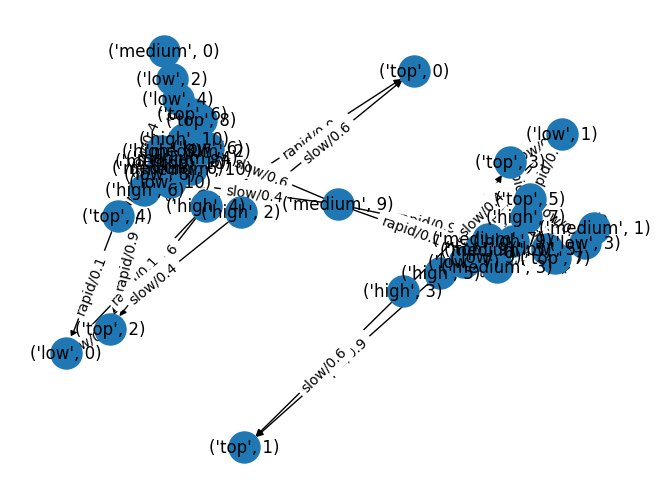

In [126]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Define the states and actions
positions = ['low', 'medium', 'high', 'top']
energies = range(11)  # energy can be 0 to 10
actions = ['slow', 'rapid']
costs = {'slow': 2, 'rapid': 4}  # energy cost for each action
gains = {'medium': 4, 'low': 0, 'high': 0, 'top': 0}  # energy gain for each position

# Add edges (transitions) to the graph
for position in positions:
    for energy in energies:
        for action in actions:
            if energy >= costs[action]:  # the action is possible
                next_energy = min(10, energy - costs[action] + gains[position])  # calculate the next energy
                if position != 'top':  # if not at the top, can move to the next higher position
                    next_position = positions[positions.index(position) + 1]
                    G.add_edge((position, energy), (next_position, next_energy), action=action, probability=0.6 if action == 'slow' else 0.9)
                if position != 'low':  # if not at the low, can slide down to the low position
                    G.add_edge((position, energy), ('low', next_energy), action=action, probability=0.4 if action == 'slow' else 0.1)

# Draw the graph
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=500)

# Draw edge labels
edge_labels = {(u, v): f"{d['action']}/{d['probability']}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()